In [1]:
import pandas as pd
import numpy as np
import sys
import os
import time
import itertools
import gc
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import use
use("Agg")
import matplotlib.pyplot as plt
import csv,argparse,os,shutil
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import csv,argparse,os,shutil
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import ElasticNet

/Users/Vinny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.


In [2]:
def etl_pipeline(df, is_train = False, create_interactions = False, fillna_dict = None,\
                 single_interaction_vars = None, higher_interaction_vars = None, df_grouping_train = None,\
                 target = None):
    assert target != None
    columns = [x.lower() for x in df.columns.tolist()]
    df.columns = columns
    df_etl = df.loc[:,:]
    if is_train == True:
        # apply some filter here
        # df_etl = df_etl.loc[(~df_etl['dob'].isnull()) & (~df_etl['loan_period'].isnull())]
        # df_etl = df_etl.loc[(~df_etl['dob'].isnull())]
        pass
        
    vars_to_one_hot_encode = []

    # encode basic variables
    for col in vars_to_one_hot_encode:
        for val in df_etl[col].unique():
            # vars_for_model.append(col + '_' + str(val))
            # print (vars_for_model[-1])
            df_etl[col + '_' + str(val)] = df_etl[col].apply(lambda x: 1 if x == val else 0)
    
    # fill missing values
    if fillna_dict is not None:
        df_etl.fillna(fillna_dict, inplace = True)
    
    df_grouping = {}
    if create_interactions == True and is_train == True:
        if single_interaction_vars is not None:
            for var_to_group in single_interaction_vars:
                print (var_to_group)
                a=df_etl.groupby([var_to_group]).agg({'total_points_target':[np.mean]})
 #               a.columns=list(map(lambda x: x[:-1] if x[-1] == '_' else x, ['_'.join(x) for x in a.columns.ravel()]))
 #               a['avg_ctr']=a['unique_clicks_sum']/a['unique_impression_sum']
                df_grouping[var_to_group]=a
                new_col_names =  [df_grouping[var_to_group].index.name] + ['_'.join([df_grouping[var_to_group].index.name] + list(x)) \
                                  for x in (df_grouping[var_to_group].columns.ravel())]
                # print (new_col_names)
                df_grouping[var_to_group].reset_index(inplace = True)
                df_grouping[var_to_group].columns = new_col_names
                for col in df_grouping[var_to_group].columns:
                    if '_count' in col:
                        df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

                df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = var_to_group, how = 'left')




        if higher_interaction_vars is not None:
            for var_to_group in higher_interaction_vars:
                print (var_to_group)
                a=df_etl.groupby(list(var_to_group)).agg({'total_points_target':[np.mean]})
           #     a.columns=list(map(lambda x: x[:-1] if x[-1] == '_' else x, ['_'.join(x) for x in a.columns.ravel()]))
        #        a['avg_ctr']=a['unique_clicks_sum']/a['unique_impression_sum']
                df_grouping[var_to_group]=a
                new_col_names =  list(var_to_group) + ['_'.join(['_'.join(var_to_group)] + list(x)) \
                                  for x in (df_grouping[var_to_group].columns.ravel())]
                df_grouping[var_to_group].reset_index(inplace = True)
                df_grouping[var_to_group].columns = new_col_names
                for col in df_grouping[var_to_group].columns:
                    if '_count' in col[-6:]:
                        df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

                df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = list(var_to_group), how = 'left')
    
    if is_train == False and create_interactions == True:
        assert df_grouping_train is not None
        for var_to_group in df_grouping_train.keys():
            df_etl = pd.merge(left = df_etl, right = df_grouping_train[var_to_group], on = var_to_group, how = 'left')  
    if is_train == True:
            return (df_etl, df_grouping)
    return (df_etl)


In [3]:
def plot_final_graph(inputdf, target_rate,population,variable,title):
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax1.bar(range(0,len(inputdf)), inputdf[population],color='c',label='#Customer',width=0.3)
    ax1.set_ylabel('Population')
    ax1.set_xlabel(variable)
    plt.title(title)
    plt.xticks(range(0,len(inputdf)), inputdf.index, rotation=45)
    
    ax1.text(1.1,0.30,'Lower',transform=ax1.transAxes)
    ax1.text(1.1,0.24,'Targets',transform=ax1.transAxes)
    ax1.annotate('', xy=(1.15,0.05), xycoords='axes fraction', xytext=(1.15,0.22),arrowprops=dict(arrowstyle="simple", color='r'))
    
    ax1.text(1.1,0.70,'Higher',transform=ax1.transAxes)
    ax1.text(1.1,0.65,'Targets',transform=ax1.transAxes)
    ax1.annotate('', xy=(1.15,0.94), xycoords='axes fraction', xytext=(1.15,0.75),arrowprops=dict(arrowstyle="simple", color='g'))
    
    ax2 = ax1.twinx()   
    ax2.plot(range(0,len(inputdf)), inputdf[target_rate],color='g',label='Avg Points')
    ax2.set_ylabel('Avg Points')
    fig.savefig('Plots/%s.png'%variable)

def get_next_range(arr,group_range,start):
    if group_range + start >=100:
        return 100
    elif (100 - group_range/2) < start + group_range:
        return 100
    elif arr[-1] == arr[start]:
        return 100
    elif (arr[start+group_range] == arr[start]) or (arr[start] < 0):
        return np.max([np.min(np.where(arr > arr[start])),np.min(np.where(arr >= 0))])
    else:
        return group_range + start
    
def get_risk_table_categorical(inputdf, variable , target, variable_desc, cutoff = 1000):
    df1 = inputdf[[variable,target]]
    df1[variable][df1[variable].isnull()]="MISSING"
    
    freq1 = df1[variable].value_counts()
    dict1 = {}
    for key,value in zip(list(freq1.index), list(freq1)):
        if value < cutoff:
            dict1[key] = "OTHER"
        else:
            dict1[key] = str(key)
 
    df1["Clean_%s"%variable] = df1[[variable]].applymap(dict1.get)
    df2 = df1.groupby(["Clean_%s"%variable]).agg([np.mean, np.sum, np.size ])
    df2 = df2[target][['mean','sum','size']]

    #df2 = pd.crosstab(df1["Clean_%s"%variable], df1[target],colnames=[target])
    #df2.columns = ['Bads','Goods']
    df2['Avg Points'] = df2['mean']
    df2['Population Percentage'] = 1.0*df2['size']/len(inputdf)
    df2.sort_values('Avg Points', inplace=True)
    df2['Variable'] = variable
    plot_final_graph(df2,'Avg Points','Population Percentage',variable,variable_desc)
    return df2

def get_risk_table_numeric(df,var,target,groups,title,special_values):
    df1 = df[[var,target]]
    df2 = df[[var,target]]
    if len(special_values) > 0:
        df1.replace(special_values,[np.nan for x in special_values],inplace=True)
    df3 = df2[df1[var].isnull()]
    df3.fillna(-999,inplace=True)
    df1.dropna(inplace=True)
    
    bins = []
    begin_traverse = 0
    percentiles = np.array([np.percentile(df1[var],p) for p in range(0,100)])
    group_range = int(100/groups)
    
    while (begin_traverse <100):
        bins += [percentiles[begin_traverse]]
        begin_traverse = get_next_range(percentiles,group_range,begin_traverse)
    
    bins.append(np.max(df1[var])+1)
    df1.loc[:,'BINS'] = pd.cut(df1[var], bins, right=False, labels=None, retbins=False, precision=3, include_lowest=False)
    df4 = df1.groupby('BINS').agg([np.mean, np.sum, np.size ])
    df5 = df4[target][['mean','sum','size']]
    df5['Bin Mean'] = df4[var][['mean']]
    df5['Avg Points'] = df5['mean']
    df5['Population Percentage'] = 1.0*df5['size']/len(df)
    df5.sort_values(by='Bin Mean', inplace=True) 
    
    if len(df3) > 0:
        df4 = df3.groupby(var).agg([ np.mean, sum, np.size ])
        df6 = df4[target][['mean','sum','size']]
        df6['Bin Mean'] = df4.index
        df6['Avg Points'] = df6['mean']
        df6['Population Percentage'] = 1.0*df6['size']/len(df)
        df6.sort('Bin Mean', inplace=True) 
        df5 = pd.concat([df6,df5])
    plot_final_graph(df5,'Avg Points','Population Percentage',var,title)
    df5['Variable'] = var
    return df5

# Preparing Data

In [4]:
player_desc = pd.read_csv('player-info.csv')

player_desc = player_desc[['element_type','id','team']]

gw_data=pd.DataFrame()
for i in range(38):
    test = pd.read_csv('gws/gw%s.csv'%(i+1), encoding = "ISO-8859-1")
    gw_data = gw_data.append(test)

gw_data = pd.merge(gw_data,player_desc,left_on='element',right_on='id',how='left')

#gw_data_gk = gw_data[gw_data['element_type']==1]

#gw_data_gk.describe().to_csv('gk_dd.csv')

def func(x,var,win):
    x[var+'_rolling_%s'%(win)] = x.rolling(on='round',window=win)[var].sum().fillna(0)
    return x

gw_data_gk = gw_data[['name',
                         'assists',
'attempted_passes',
'big_chances_created',
'bonus',
'bps',
'clean_sheets',
'clearances_blocks_interceptions',
'completed_passes',
'creativity',
'dribbles',
'element',
'errors_leading_to_goal',
'errors_leading_to_goal_attempt',
'fouls',
'goals_conceded',
'ict_index',
'influence',
'key_passes',
'minutes',
'opponent_team',
'own_goals',
'penalties_conceded',
'penalties_saved',
'recoveries',
'round',
'saves',
'selected',
'tackled',
'tackles',
'target_missed',
'team_a_score',
'team_h_score',
'threat',
'was_home',
'total_points',
'transfers_in',
'transfers_out',
'winning_goals',
'yellow_cards',
'team',
'big_chances_missed',
'ea_index',
'goals_scored',
'loaned_in',
'loaned_out',
'offside',
'open_play_crosses',
'penalties_missed',
'red_cards',
'element_type']]

In [5]:
for col in ['assists',
'attempted_passes',
'big_chances_created',
'bonus',
'bps',
'clean_sheets',
'clearances_blocks_interceptions',
'completed_passes',
'creativity',
'dribbles',
'errors_leading_to_goal',
'errors_leading_to_goal_attempt',
'fouls',
'goals_conceded',
'ict_index',
'influence',
'key_passes',
'minutes',
'own_goals',
'penalties_conceded',
'penalties_saved',
'recoveries',
'saves',
'selected',
'tackled',
'tackles',
'target_missed',
'threat',
'total_points',
'transfers_in',
'transfers_out',
'winning_goals',
'yellow_cards',
'big_chances_missed',
'ea_index',
'goals_scored',
'loaned_in',
'loaned_out',
'offside',
'open_play_crosses',
'penalties_missed',
'red_cards']:
    gw_data_gk = gw_data_gk.groupby('element').apply(func,col,10)

In [6]:
data = gw_data_gk[gw_data_gk['round']>=10]
data_target = data.copy()
data_target['round'] = data_target['round']-1
data_target = data_target[['round','element','total_points','opponent_team','was_home']]
data_target = data_target.rename(index=str, columns={"total_points": "total_points_target"})
data = pd.merge(data,data_target,on=['round','element'],how='left')
data = data[~data['element_type'].isnull()]
data = data[(data['minutes']>0) &(~data['was_home_y'].isnull())]
data['was_home_y'] = data['was_home_y'].astype(int)

In [7]:
data = data[~(data['total_points_target'].isnull())]
test = data[data['round']>=28]
train = data

In [8]:
df_grouping_train=etl_pipeline(df=train,is_train = True, create_interactions = True, fillna_dict = None,
                 single_interaction_vars = ['team','opponent_team_y','was_home_y','element_type'], 
             higher_interaction_vars = [('team','was_home_y'),
                                        ('team','element_type'),
                                        ('was_home_y','element_type'),
                                        ('opponent_team_y','element_type'),
                                        ('opponent_team_y','was_home_y')], df_grouping_train = None,
                 target = 'total_points_target')


df_grouping_test=etl_pipeline(df=test,is_train = False, create_interactions = True, fillna_dict = None,
               single_interaction_vars = ['team','opponent_team_y','was_home_y','element_type'], 
              higher_interaction_vars = [('team','was_home_y'),
                                         ('team','element_type'),
                                         ('was_home_y','element_type'),
                                         ('opponent_team_y','element_type'),
                                         ('opponent_team_y','was_home_y')], df_grouping_train = df_grouping_train[1],
                 target = 'total_points_target')


team
opponent_team_y
was_home_y
element_type
('team', 'was_home_y')
('team', 'element_type')
('was_home_y', 'element_type')
('opponent_team_y', 'element_type')
('opponent_team_y', 'was_home_y')


In [9]:
train_clean=df_grouping_train[0]
test_clean=df_grouping_test

In [10]:
#test_clean_gk = test_clean[test_clean['element_type'].isin([3,4])]
#train_clean_gk = train_clean[train_clean['element_type'].isin([3,4])]

In [11]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = (predictions - test_labels)
    me = 100 * np.mean(errors) / np.mean(test_labels)
    mae = 100 * np.mean(abs(errors)) / np.mean(test_labels)
    
    print('Mean Error By Mean: {:0.2f}%.'.format(me))
    print('Mean Abs Error By Mean = {:0.2f}%.'.format(mae))
    print('Root Mean Sq Error = {:0.2f}%.'.format(sqrt(mean_squared_error(test_labels, predictions))))

def train_rf_cv(train_clean,test_clean,var_remove):    
    param_grid = {
        'max_depth': [ 2,3,4,5,6],
        'min_samples_leaf': [5,10,20, 30],
        'n_estimators': [ 1,2,3,4,5,10]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(train_clean[idv].drop(var_remove,axis=1), train_clean['total_points_target'])

    grid_search.best_params_


    best_grid = grid_search.best_estimator_
    print ("Train Accuracy... \n")
    grid_accuracy = evaluate(best_grid, train_clean[idv].drop(var_remove,axis=1), train_clean['total_points_target'])
    print ("\n Test Accuracy")
    grid_accuracy = evaluate(best_grid, test_clean[idv].drop(var_remove,axis=1), test_clean['total_points_target'])
    
    feature_import = pd.DataFrame(data=best_grid.feature_importances_, index=train_clean[idv].drop(var_remove,axis=1).columns.values, columns=['values'])
    feature_import.sort_values(['values'], ascending=False, inplace=True)
    feature_import.reset_index(level=0, inplace=True)
    sns.barplot(x='index', y='values', data=feature_import, palette='deep')
    plt.show()
    return (best_grid,feature_import.transpose())

In [12]:
idv=[
    'name',
    'total_points_target',
    'total_points',
    'team_total_points_target_mean',
    'opponent_team_y_total_points_target_mean',
    'was_home_y_total_points_target_mean',
    'team_was_home_y_total_points_target_mean',
    'opponent_team_y_was_home_y_total_points_target_mean',
    'team_element_type_total_points_target_mean',
    'was_home_y_element_type_total_points_target_mean',
    'opponent_team_y_element_type_total_points_target_mean',
    'element_type_total_points_target_mean',
    'assists_rolling_10',
'attempted_passes_rolling_10',
'big_chances_created_rolling_10',
'bonus_rolling_10',
'bps_rolling_10',
'clean_sheets_rolling_10',
'clearances_blocks_interceptions_rolling_10',
'completed_passes_rolling_10',
'creativity_rolling_10',
'dribbles_rolling_10',
'errors_leading_to_goal_rolling_10',
'errors_leading_to_goal_attempt_rolling_10',
'fouls_rolling_10',
'goals_conceded_rolling_10',
'ict_index_rolling_10',
'influence_rolling_10',
'key_passes_rolling_10',
'minutes_rolling_10',
'own_goals_rolling_10',
'penalties_conceded_rolling_10',
'penalties_saved_rolling_10',
'recoveries_rolling_10',
'saves_rolling_10',
'selected_rolling_10',
'tackled_rolling_10',
'tackles_rolling_10',
'target_missed_rolling_10',
'threat_rolling_10',
'total_points_rolling_10',
'transfers_in_rolling_10',
'transfers_out_rolling_10',
'winning_goals_rolling_10',
'yellow_cards_rolling_10',
'big_chances_missed_rolling_10',
'goals_scored_rolling_10',
'offside_rolling_10',
'open_play_crosses_rolling_10',
'penalties_missed_rolling_10',
'red_cards_rolling_10'
]

# Training the model

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.8s finished


Train Accuracy... 

Mean Error By Mean: 0.13%.
Mean Abs Error By Mean = 73.29%.
Root Mean Sq Error = 2.69%.

 Test Accuracy
Mean Error By Mean: 0.33%.
Mean Abs Error By Mean = 74.05%.
Root Mean Sq Error = 2.72%.


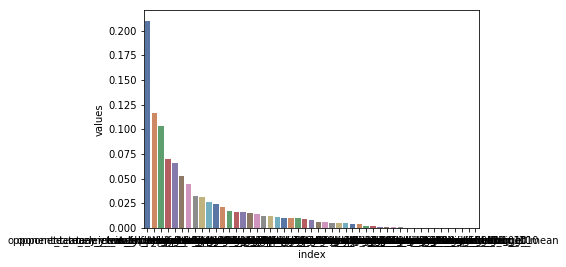

In [13]:
model_with_ctr=train_rf_cv(train_clean,test_clean,['total_points_target','name'])

In [14]:
def train_lr_cv(train_clean,test_clean,var_remove):    
    param_grid = {
        'alpha': [ 0.1,0.3,0.5,1,2],
        'l1_ratio': [0,0.5, 1],
        'normalize': [ True, False]}
    rf = ElasticNet(max_iter=5000)
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring ='neg_mean_squared_error')
    grid_search.fit(train_clean[idv].drop(var_remove,axis=1), train_clean['total_points_target'])

    grid_search.best_params_


    best_grid = grid_search.best_estimator_
    print ("Train Accuracy... \n")
    grid_accuracy = evaluate(best_grid, train_clean[idv].drop(var_remove,axis=1), train_clean['total_points_target'])
    print ("\n Test Accuracy")
    grid_accuracy = evaluate(best_grid, test_clean[idv].drop(var_remove,axis=1), test_clean['total_points_target'])
    
    feature_import = pd.DataFrame(data=best_grid.coef_, index=train_clean[idv].drop(var_remove,axis=1).columns.values, columns=['values'])
    feature_import.sort_values(['values'], ascending=False, inplace=True)
    feature_import.reset_index(level=0, inplace=True)
    sns.barplot(x='index', y='values', data=feature_import, palette='deep')
    plt.show()
    return (best_grid,feature_import.transpose())

# Best Model Configuration

In [15]:
model_with_ctr[0]

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=30, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
#model_with_ctr_lr=train_lr_cv(train_clean,test_clean,['total_points_target','name'])

In [17]:
#get_risk_table_numeric(train_clean_gk,'clean_sheets_rolling_10','total_points_target',10,'clean_sheets',special_values=[])


# Variable importance

In [18]:
model_with_ctr[1].transpose()

,index,values
0,ict_index_rolling_10,0.209879
1,opponent_team_y_element_type_total_points_targ...,0.116167
2,opponent_team_y_was_home_y_total_points_target...,0.103343
3,team_element_type_total_points_target_mean,0.0698605
4,total_points_rolling_10,0.0655226
5,influence_rolling_10,0.0528274
6,team_was_home_y_total_points_target_mean,0.0446838
7,threat_rolling_10,0.0325602
8,offside_rolling_10,0.0313107
9,transfers_out_rolling_10,0.0265404


# Predictions for next season

In [19]:
player_desc = pd.read_csv('players_raw_18_19.csv')

player_desc = player_desc[['element_type','id','team']]

gw_data=pd.DataFrame()
for i in range(15):
    test = pd.read_csv('gws18/gw%s.csv'%(i+1), encoding = "ISO-8859-1")
    gw_data = gw_data.append(test)

gw_data = pd.merge(gw_data,player_desc,left_on='element',right_on='id',how='left')

#gw_data_gk = gw_data[gw_data['element_type']==1]

#gw_data_gk.describe().to_csv('gk_dd.csv')

def func(x,var,win):
    x[var+'_rolling_%s'%(win)] = x.rolling(on='round',window=win)[var].sum().fillna(0)
    return x

gw_data_gk = gw_data[['name',
                         'assists',
'attempted_passes',
'big_chances_created',
'bonus',
'bps',
'clean_sheets',
'clearances_blocks_interceptions',
'completed_passes',
'creativity',
'dribbles',
'element',
'errors_leading_to_goal',
'errors_leading_to_goal_attempt',
'fouls',
'goals_conceded',
'ict_index',
'influence',
'key_passes',
'minutes',
'opponent_team',
'own_goals',
'penalties_conceded',
'penalties_saved',
'recoveries',
'round',
'saves',
'selected',
'tackled',
'tackles',
'target_missed',
'team_a_score',
'team_h_score',
'threat',
'was_home',
'total_points',
'transfers_in',
'transfers_out',
'winning_goals',
'yellow_cards',
'team',
'big_chances_missed',
'ea_index',
'goals_scored',
'loaned_in',
'loaned_out',
'offside',
'open_play_crosses',
'penalties_missed',
'red_cards',
'element_type',
'value']]

In [20]:
for col in ['assists',
'attempted_passes',
'big_chances_created',
'bonus',
'bps',
'clean_sheets',
'clearances_blocks_interceptions',
'completed_passes',
'creativity',
'dribbles',
'errors_leading_to_goal',
'errors_leading_to_goal_attempt',
'fouls',
'goals_conceded',
'ict_index',
'influence',
'key_passes',
'minutes',
'own_goals',
'penalties_conceded',
'penalties_saved',
'recoveries',
'saves',
'selected',
'tackled',
'tackles',
'target_missed',
'threat',
'total_points',
'transfers_in',
'transfers_out',
'winning_goals',
'yellow_cards',
'big_chances_missed',
'ea_index',
'goals_scored',
'loaned_in',
'loaned_out',
'offside',
'open_play_crosses',
'penalties_missed',
'red_cards']:
    gw_data_gk = gw_data_gk.groupby('element').apply(func,col,10)

In [21]:
fixtures = pd.read_csv('epl-2018-GMTStandardTime.csv')
fixtures = fixtures[(fixtures['Round Number']<=18) & (fixtures['Round Number']>=13)]
fixtures = fixtures.rename(index=str,columns = {'Round Number':'round'})

In [22]:
player_team = gw_data_gk[['element','team']].drop_duplicates()
master= pd.DataFrame()
for i in range(13,18):
    player_team['round']=i
    master = master.append(player_team)
master = pd.merge(master,fixtures,left_on=['round','team'],right_on=['round','Home Team'],how='left')
master['opponent_team'] = master['Away Team']
master['was_home'] = np.where(master['Away Team'].isnull(),False,True)
master = master.drop(['Home Team','Away Team'],axis=1)
master = pd.merge(master,fixtures,left_on=['round','team'],right_on=['round','Away Team'],how='left')
master['opponent_team'] = np.where(master['opponent_team'].isnull(),master['Home Team'],master['opponent_team'])
master = master.drop(['Home Team','Away Team'],axis=1)


In [23]:
data = gw_data_gk[gw_data_gk['round']==15]
data = data.drop('round',axis=1)
data_target = master[['round','element','opponent_team','was_home']]
#data_target = data_target.rename(index=str, columns={"total_points": "total_points_target"})
data = pd.merge(data,data_target,on=['element'],how='left')
data = data[~data['element_type'].isnull()]
data = data[(data['minutes']>0) &(~data['was_home_y'].isnull())]
data['was_home_y'] = data['was_home_y'].astype(int)
data['total_points_target'] = 0

In [24]:
test = data
df_grouping_test=etl_pipeline(df=data,is_train = False, create_interactions = True, fillna_dict = None,
               single_interaction_vars = ['team','opponent_team_y','was_home_y','element_type'], 
              higher_interaction_vars = [('team','was_home_y'),
                                         ('team','element_type'),
                                         ('was_home_y','element_type'),
                                         ('opponent_team_y','element_type'),
                                         ('opponent_team_y','was_home_y')], df_grouping_train = df_grouping_train[1],
                 target = 'total_points_target')


In [25]:
test_clean=df_grouping_test

In [26]:
test_clean_11 = test_clean.copy()
test_features = test_clean[idv].drop(['total_points_target','name'],axis=1)
test_labels = test_clean['total_points_target']
predictions = model_with_ctr[0].predict(test_features)
test_clean['prediction'] = predictions

# Choosing Best 11

In [27]:
test_features = test_clean_11[idv].drop(['total_points_target','name'],axis=1)
test_clean_11['prediction'] = model_with_ctr[0].predict(test_features)
test_clean_11 = test_clean_11.drop_duplicates(['name','round'],keep='first')

test_clean_11=test_clean_11.groupby(['name','element_type','value']).agg({'prediction':'sum','total_points_target':'sum'}).reset_index()

test_labels = test_clean_11['total_points_target']
predictions = test_clean_11['prediction']
#print("mean squared error "+str(sqrt(mean_squared_error(test_labels, predictions))))
test_clean['prediction'] = predictions


#test_clean_gk[['name','team','round','total_points_rolling_10','opponent_team_y','was_home_y','prediction','total_points_target']].to_csv('predGk.csv')
#test_clean = test_clean.drop_duplicates(['name','round'],keep='first')

gk_ordered_pred=pd.DataFrame()
for x in test_clean_11.groupby(['element_type']):
    df_temp = x[1] 
    df_temp = df_temp.sort_values(by='prediction',ascending =False)
    df_temp['player_rank_pred']=list(range(1,len(df_temp)+1))
  #  df_temp['round'] = x[0][0]
    df_temp['element_type'] = x[0]
    gk_ordered_pred = gk_ordered_pred.append(df_temp.copy())

gk_ordered_actual=pd.DataFrame()
   
for x in test_clean_11.groupby(['element_type']):
    df_temp = x[1] 
    df_temp = df_temp.sort_values(by='total_points_target',ascending =False)
    df_temp['player_rank_actual']=list(range(1,len(df_temp)+1))
   # df_temp['round'] = x[0][0]
    df_temp['element_type'] = x[0]
    gk_ordered_actual = gk_ordered_actual.append(df_temp.copy())
    

# ordering = pd.merge(gk_ordered_actual[['name','round','team','opponent_team_y','was_home_y','player_rank_actual','total_points_target','prediction']],
#                     gk_ordered_pred[['name','round','player_rank_pred','element_type']],how='left',on=['name','round'])
ordering = pd.merge(gk_ordered_actual,
                     gk_ordered_pred,how='left',on=['name'])


In [28]:
formation = [3,7,8,4]
best_eleven = pd.DataFrame()
for i,v in enumerate(formation):
    best_eleven = best_eleven.append(ordering[(ordering['element_type_x']==i+1) & (ordering['player_rank_pred']<=v)])
best_eleven['value_x'] =  best_eleven['value_x']/10   
best_eleven[['name','element_type_x','value_x','player_rank_pred']].to_csv('Best_Eleven.csv')   

# Validation Checks

In [29]:
test_clean_copy = test_clean.copy()

In [30]:
test_clean = test_clean_copy.copy()

In [31]:
test_features = test_clean[idv].drop(['total_points_target','name'],axis=1)
test_clean['predictions'] = model_with_ctr[0].predict(test_features)
test_clean = test_clean.drop_duplicates(['name','round'],keep='first')

test_clean=test_clean.groupby(['name','element_type']).agg({'prediction':'sum','total_points_target':'sum'}).reset_index()

test_labels = test_clean['total_points_target']
predictions = test_clean['prediction']
print("mean squared error "+str(sqrt(mean_squared_error(test_labels, predictions))))
test_clean['prediction'] = predictions


#test_clean_gk[['name','team','round','total_points_rolling_10','opponent_team_y','was_home_y','prediction','total_points_target']].to_csv('predGk.csv')
#test_clean = test_clean.drop_duplicates(['name','round'],keep='first')

gk_ordered_pred=pd.DataFrame()
for x in test_clean.groupby(['element_type']):
    df_temp = x[1] 
    df_temp = df_temp.sort_values(by='prediction',ascending =False)
    df_temp['player_rank_pred']=list(range(1,len(df_temp)+1))
  #  df_temp['round'] = x[0][0]
    df_temp['element_type'] = x[0]
    gk_ordered_pred = gk_ordered_pred.append(df_temp.copy())

gk_ordered_actual=pd.DataFrame()
   
for x in test_clean.groupby(['element_type']):
    df_temp = x[1] 
    df_temp = df_temp.sort_values(by='total_points_target',ascending =False)
    df_temp['player_rank_actual']=list(range(1,len(df_temp)+1))
   # df_temp['round'] = x[0][0]
    df_temp['element_type'] = x[0]
    gk_ordered_actual = gk_ordered_actual.append(df_temp.copy())
    

# ordering = pd.merge(gk_ordered_actual[['name','round','team','opponent_team_y','was_home_y','player_rank_actual','total_points_target','prediction']],
#                     gk_ordered_pred[['name','round','player_rank_pred','element_type']],how='left',on=['name','round'])
ordering = pd.merge(gk_ordered_actual,
                     gk_ordered_pred,how='left',on=['name'])

n=11
a = ordering [ordering['player_rank_actual']<=n]
a['correct'] = np.where(a['player_rank_pred']<=n,1,0)
print("Out of Top "+str(n)+", "+str(a['correct'].mean())+" were correct")

mean squared error 28.923385906922324
Out of Top 11, 0.2727272727272727 were correct


/Users/Vinny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
def performance_total_score(x):
    
    pred = x[(x['element_type']==1) & (x['player_rank_pred']<=1)]['total_points_target'].sum()
    best = x[(x['element_type']==1) & (x['player_rank_actual']<=1)]['total_points_target'].sum()
    
    pred_def = x[(x['element_type']==2) & (x['player_rank_pred']<=4)]['total_points_target'].sum()
    best_def = x[(x['element_type']==2) & (x['player_rank_actual']<=4)]['total_points_target'].sum()
    
    pred_mid = x[(x['element_type']==3) & (x['player_rank_pred']<=3)]['total_points_target'].sum()
    best_mid = x[(x['element_type']==3) & (x['player_rank_actual']<=3)]['total_points_target'].sum()
   
    pred_fw = x[(x['element_type']==4) & (x['player_rank_pred']<=3)]['total_points_target'].sum()
    best_fw = x[(x['element_type']==4) & (x['player_rank_actual']<=3)]['total_points_target'].sum()
    d = {}
    d['pred_gk'] = pred
    d['best_gk'] = best
    d['pred_def'] = pred_def
    d['best_def'] = best_def    
    d['pred_mid'] = pred_mid
    d['best_mid'] = best_mid
    d['pred_fw'] = pred_fw
    d['best_fw'] = best_fw  
    d['pred_total'] = pred+pred_def+pred_mid+pred_fw
    d['best_total'] = best+best_def+best_mid+best_fw
    return pd.Series(d,index=['pred_gk','best_gk','pred_def','best_def','pred_mid','best_mid','pred_fw','best_fw','pred_total','best_total'])

In [33]:
x = ordering[(ordering['round']==16)]
x[(x['element_type']==4) & (x['player_rank_actual']<=5)]

KeyError: 'round'

In [ ]:
x = ordering[(ordering['round']==16)]
x[(x['element_type']==4) & (x['player_rank_pred']<=5)]

In [ ]:
a = ordering.groupby('round').apply(performance_total_score).reset_index()
print(a['pred_fw'].sum(),a['best_fw'].sum())

# Bivariate Plots

In [ ]:
get_risk_table_numeric(data,'assists_rolling_10','total_points_target',10,'assists',special_values=[])
get_risk_table_numeric(data,'attempted_passes_rolling_10','total_points_target',10,'attempted_passes',special_values=[])
get_risk_table_numeric(data,'big_chances_created_rolling_10','total_points_target',10,'big_chances_created',special_values=[])
get_risk_table_numeric(data,'bonus_rolling_10','total_points_target',10,'bonus',special_values=[])
get_risk_table_numeric(data,'bps_rolling_10','total_points_target',10,'bps',special_values=[])
get_risk_table_numeric(data,'clean_sheets_rolling_10','total_points_target',10,'clean_sheets',special_values=[])
get_risk_table_numeric(data,'clearances_blocks_interceptions_rolling_10','total_points_target',10,'clearances_blocks_interceptions',special_values=[])
get_risk_table_numeric(data,'completed_passes_rolling_10','total_points_target',10,'completed_passes',special_values=[])
get_risk_table_numeric(data,'creativity_rolling_10','total_points_target',10,'creativity',special_values=[])
get_risk_table_numeric(data,'dribbles_rolling_10','total_points_target',10,'dribbles',special_values=[])
get_risk_table_numeric(data,'errors_leading_to_goal_rolling_10','total_points_target',10,'errors_leading_to_goal',special_values=[])
get_risk_table_numeric(data,'errors_leading_to_goal_attempt_rolling_10','total_points_target',10,'errors_leading_to_goal_attempt',special_values=[])
get_risk_table_numeric(data,'fouls_rolling_10','total_points_target',10,'fouls',special_values=[])
get_risk_table_numeric(data,'goals_conceded_rolling_10','total_points_target',10,'goals_conceded',special_values=[])
get_risk_table_numeric(data,'ict_index_rolling_10','total_points_target',10,'ict_index',special_values=[])
get_risk_table_numeric(data,'influence_rolling_10','total_points_target',10,'influence',special_values=[])
get_risk_table_numeric(data,'key_passes_rolling_10','total_points_target',10,'key_passes',special_values=[])
get_risk_table_numeric(data,'minutes_rolling_10','total_points_target',10,'minutes',special_values=[])
get_risk_table_numeric(data,'own_goals_rolling_10','total_points_target',10,'own_goals',special_values=[])
get_risk_table_numeric(data,'penalties_conceded_rolling_10','total_points_target',10,'penalties_conceded',special_values=[])
get_risk_table_numeric(data,'penalties_saved_rolling_10','total_points_target',10,'penalties_saved',special_values=[])
get_risk_table_numeric(data,'recoveries_rolling_10','total_points_target',10,'recoveries',special_values=[])
get_risk_table_numeric(data,'saves_rolling_10','total_points_target',10,'saves',special_values=[])
get_risk_table_numeric(data,'selected_rolling_10','total_points_target',10,'selected',special_values=[])
get_risk_table_numeric(data,'tackled_rolling_10','total_points_target',10,'tackled',special_values=[])
get_risk_table_numeric(data,'tackles_rolling_10','total_points_target',10,'tackles',special_values=[])
get_risk_table_numeric(data,'target_missed_rolling_10','total_points_target',10,'target_missed',special_values=[])
get_risk_table_numeric(data,'threat_rolling_10','total_points_target',10,'threat',special_values=[])
get_risk_table_numeric(data,'total_points_rolling_10','total_points_target',10,'total_points',special_values=[])
get_risk_table_numeric(data,'transfers_in_rolling_10','total_points_target',10,'transfers_in',special_values=[])
get_risk_table_numeric(data,'transfers_out_rolling_10','total_points_target',10,'transfers_out',special_values=[])
get_risk_table_numeric(data,'winning_goals_rolling_10','total_points_target',10,'winning_goals',special_values=[])
get_risk_table_numeric(data,'yellow_cards_rolling_10','total_points_target',10,'yellow_cards',special_values=[])
get_risk_table_numeric(data,'big_chances_missed_rolling_10','total_points_target',10,'big_chances_missed',special_values=[])
get_risk_table_numeric(data,'ea_index_rolling_10','total_points_target',10,'ea_index',special_values=[])
get_risk_table_numeric(data,'goals_scored_rolling_10','total_points_target',10,'goals_scored',special_values=[])
get_risk_table_numeric(data,'loaned_in_rolling_10','total_points_target',10,'loaned_in',special_values=[])
get_risk_table_numeric(data,'loaned_out_rolling_10','total_points_target',10,'loaned_out',special_values=[])
get_risk_table_numeric(data,'offside_rolling_10','total_points_target',10,'offside',special_values=[])
get_risk_table_numeric(data,'open_play_crosses_rolling_10','total_points_target',10,'open_play_crosses',special_values=[])
get_risk_table_numeric(data,'penalties_missed_rolling_10','total_points_target',10,'penalties_missed',special_values=[])
get_risk_table_numeric(data,'red_cards_rolling_10','total_points_target',10,'red_cards',special_values=[])


In [ ]:
get_risk_table_categorical(data, 'team' , 'total_points_target', 'Team', cutoff = 10)

In [ ]:
get_risk_table_categorical(data, 'team' , 'total_points_target', 'Team', cutoff = 10)